# CP 4 Aprendizaje de Máquinas
---

## Logistic Regression

In [1]:
from pathlib import Path

path_p = Path("txt_sentoken/pos")
path_n = Path("txt_sentoken/neg")

ds_p = list(path_p.iterdir())     # directorio donde están las críticas positivas
ds_n = list(path_n.iterdir())     # directorio donde están las críticas negativas

def convert_file_to_text(file_path: Path) -> str:
    with open(file_path) as f:
        return ''.join(f.readlines())
    
texts_p = [convert_file_to_text(file) for file in ds_p]    # Lista de críticas positivas
texts_n = [convert_file_to_text(file) for file in ds_n]    # Lista de críticas negativas

### Ejercicio 1: Logistic Regression aplicado al dataset de _Rotten Tomatoes_

In [2]:
from sklearn.feature_extraction.text import CountVectorizer 

cv = CountVectorizer()
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()

y = [1]*1000 + [0]*1000

In [3]:
X.shape

(2000, 39659)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70)

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.8433333333333334

### Ejercicio 2: Aplicando la Matriz de Confusión

In [7]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

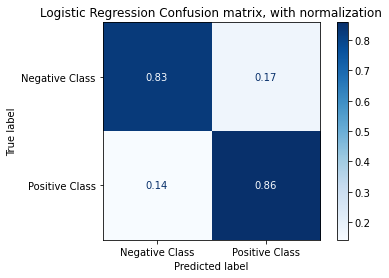

In [8]:
disp = plot_confusion_matrix(lr_model, X_test, y_test,
                             display_labels=['Negative Class', 'Positive Class'],
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

### Ejercicio 3: Probando la clasificación de un texto en específico

In [9]:
lr_model.classes_

array([0, 1])

In [10]:
test_review = cv.transform(["I did not enjoy the movie"])
lr_model.predict_proba(test_review)

array([[0.61243713, 0.38756287]])

### Ejercicio 4: Generación de Bigramas 

In [11]:
import numpy as np
import seaborn as sns

In [12]:
cv = CountVectorizer(binary=True, min_df = 10, max_df = 0.95, ngram_range=(2,2))
X = cv.fit_transform(texts_p + texts_n)
X = X.toarray()

In [13]:
X.shape

(2000, 13788)

### Ejercicio 5: Ideas para Mejorar: Utilizar Bigramas con Regresión Logística

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70)

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.8116666666666666

### Ejercicio 6: Vizualizando los Bigramas más Importantes

In [17]:
feature_importance = lr_model.coef_[0]
sorted_idx = np.argsort(feature_importance)

In [18]:
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['man who', 'is an', 'the world', 'due to', 'the best', 'very well', 'but it', 'one of', 'the right', 'and it']


In [19]:
top_10_pos_importance = feature_importance[sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_importance)

[0.48693995 0.47766991 0.47021888 0.44780772 0.44613923 0.44441952
 0.44144262 0.43616237 0.43218219 0.42622416]


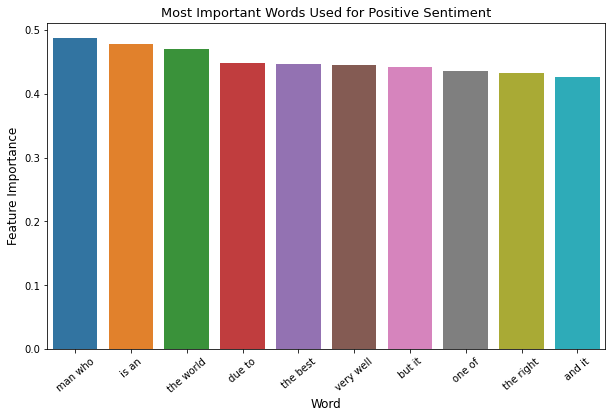

In [20]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_pos_w, y=top_10_pos_importance)
plt.title("Most Important Words Used for Positive Sentiment", fontsize=13)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Word', fontsize = 12);

In [21]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['the worst', 'the only', 'should have', 'could have', 'waste of', 'to be', 'supposed to', 'none of', 'to show', 'attempt to']


In [22]:
top_10_neg_importance = feature_importance[sorted_idx[:10]]
print(top_10_neg_importance)

[-0.66119719 -0.60373038 -0.58434611 -0.50352555 -0.50319117 -0.49667455
 -0.48091206 -0.4335115  -0.43219577 -0.41641223]


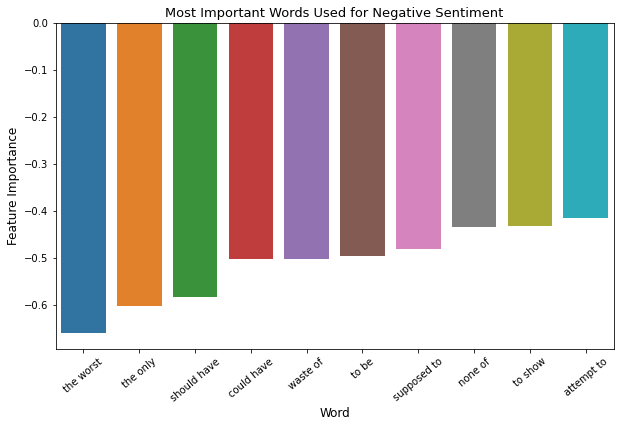

In [23]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_neg_w, y=top_10_neg_importance)
plt.title("Most Important Words Used for Negative Sentiment", fontsize = 13)
x_locs, x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [24]:
test_review = cv.transform(["I did not enjoy the movie"])
lr_model.predict_proba(test_review)

array([[0.59620043, 0.40379957]])

### Ejercicio 7: Ideas para Mejorar: Disminuir el umbral de corte de probabilidad

In [25]:
import pandas as pd
from sklearn.metrics import accuracy_score

In [26]:
pred_proba_df = pd.DataFrame(lr_model.predict_proba(X_test))
threshold_list = [0.3, 0.4, 0.45, 0.5]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = round(accuracy_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('Accuracy: {}'.format(test_accuracy))


******** For i = 0.3 ******
Accuracy: 0.768

******** For i = 0.4 ******
Accuracy: 0.79

******** For i = 0.45 ******
Accuracy: 0.795

******** For i = 0.5 ******
Accuracy: 0.812
